# Running standard bp on mnist 

## Refer to this site - https://mlfromscratch.com/neural-network-tutorial/#/

# ALso this site : https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%201/

In [3]:
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time

x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

Using TensorFlow backend.
c:\Users\Rohit\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.accuracy_over_epochs = []

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):
        params = self.params
        #print(params)

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        training_samples = y_train.shape[1]
        #print(training_samples)
        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        #change_w['W3'] = np.outer(error, params['A2'])#we use np.outer since we have only training sample!
        change_w['W3'] = np.matmul(error, params['A2'].T)

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        #change_w['W2'] = np.outer(error, params['A1'])
        change_w['W2'] = np.matmul(error, params['A1'].T)

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        #change_w['W1'] = np.outer(error, params['A0'])
        change_w['W1'] = np.matmul(error, params['A0'].T)

        #print(change_w['W2'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y), 
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''
        
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)
    

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)
            
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))
            self.accuracy_over_epochs.append(accuracy)
    
    def train_arr(self, x_train, y_train, x_val, y_val):
        x_train_cat = np.column_stack((x_train))
        y_train_cat = y_train.T
        start_time = time.time()
        for iteration in range(self.epochs):
            output = self.forward_pass(x_train_cat)
            changes_to_w = self.backward_pass(y_train_cat, output)
            #print(changes_to_w)
            self.update_network_parameters(changes_to_w)
            
            val_accuracy = self.compute_accuracy(x_val, y_val)
            training_accuracy = self.compute_accuracy(x_train, y_train)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Training Accuracy: {2:.2f}%, Valdiation Accuracy: {3:.2f}%'.format(
                iteration+1, time.time() - start_time, 1000, val_accuracy * 100
            ))
            self.accuracy_over_epochs.append(training_accuracy)
            

In [5]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.001)
dnn.train_arr(x_train, y_train, x_val, y_val)

Epoch: 1, Time Spent: 7.31s, Training Accuracy: 1000.00%, Valdiation Accuracy: 9.86%
Epoch: 2, Time Spent: 12.61s, Training Accuracy: 1000.00%, Valdiation Accuracy: 10.35%
Epoch: 3, Time Spent: 17.76s, Training Accuracy: 1000.00%, Valdiation Accuracy: 9.24%
Epoch: 4, Time Spent: 23.08s, Training Accuracy: 1000.00%, Valdiation Accuracy: 9.22%
Epoch: 5, Time Spent: 28.07s, Training Accuracy: 1000.00%, Valdiation Accuracy: 11.48%
Epoch: 6, Time Spent: 33.28s, Training Accuracy: 1000.00%, Valdiation Accuracy: 10.35%
Epoch: 7, Time Spent: 38.33s, Training Accuracy: 1000.00%, Valdiation Accuracy: 9.68%
Epoch: 8, Time Spent: 43.27s, Training Accuracy: 1000.00%, Valdiation Accuracy: 9.70%
Epoch: 9, Time Spent: 48.31s, Training Accuracy: 1000.00%, Valdiation Accuracy: 10.57%
Epoch: 10, Time Spent: 53.26s, Training Accuracy: 1000.00%, Valdiation Accuracy: 9.24%
Epoch: 11, Time Spent: 58.35s, Training Accuracy: 1000.00%, Valdiation Accuracy: 10.35%
Epoch: 12, Time Spent: 64.09s, Training Accuracy

In [34]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100)
dnn.train(x_train, y_train, x_val, y_val)

Epoch: 1, Time Spent: 30.09s, Accuracy: 20.50%
Epoch: 2, Time Spent: 57.45s, Accuracy: 27.49%
Epoch: 3, Time Spent: 90.08s, Accuracy: 34.39%
Epoch: 4, Time Spent: 123.35s, Accuracy: 41.07%
Epoch: 5, Time Spent: 151.11s, Accuracy: 46.43%
Epoch: 6, Time Spent: 178.18s, Accuracy: 50.50%
Epoch: 7, Time Spent: 208.80s, Accuracy: 52.81%
Epoch: 8, Time Spent: 239.97s, Accuracy: 54.68%
Epoch: 9, Time Spent: 270.92s, Accuracy: 56.56%
Epoch: 10, Time Spent: 304.37s, Accuracy: 59.30%
Epoch: 11, Time Spent: 341.60s, Accuracy: 62.79%
Epoch: 12, Time Spent: 374.20s, Accuracy: 65.42%
Epoch: 13, Time Spent: 411.01s, Accuracy: 67.19%
Epoch: 14, Time Spent: 448.91s, Accuracy: 68.45%
Epoch: 15, Time Spent: 480.82s, Accuracy: 69.23%
Epoch: 16, Time Spent: 509.25s, Accuracy: 70.05%
Epoch: 17, Time Spent: 545.47s, Accuracy: 70.56%
Epoch: 18, Time Spent: 579.98s, Accuracy: 70.98%
Epoch: 19, Time Spent: 612.24s, Accuracy: 71.30%
Epoch: 20, Time Spent: 646.37s, Accuracy: 71.58%
Epoch: 21, Time Spent: 681.81s, 

Text(0.5, 1.0, 'Accuracy')

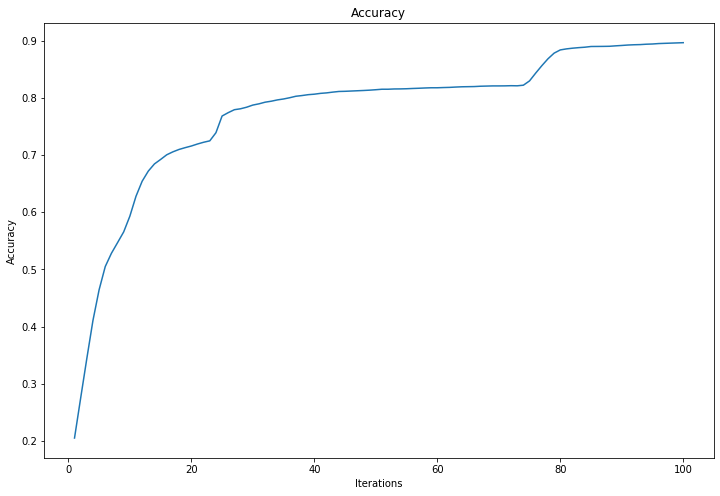

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.plot(range(1, 101), dnn.accuracy_over_epochs)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
# plt.ylim(80,100)
plt.title("Accuracy")
#dnn.accuracy_over_epochs

In [5]:
dnn_my = DeepNeuralNetwork(sizes=[784, 500, 500, 10], epochs=20)
dnn_my.train(x_train, y_train, x_val, y_val)

KeyboardInterrupt: 

# Performing Weight perturbation with the above structure

In [1]:
class DeepNeuralNetwork_withWeighPert():
    def __init__(self, sizes, perturbation, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.perturbation = perturbation
        self.l_rate = l_rate
        self.accuracy_over_epochs = []

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']
    
    def perturbweightarray(self, weight_array):
        '''
            Perturbs each weight of the passed weight array and retur
        '''
            len_x, len_y = weight_array.shape
            weight_array_copy = weight_array.copy()
            for i in range(len_x):
                for j in range(len_y):
                    perturbed_


    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y), 
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''
        
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)
            
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))
            self.accuracy_over_epochs.append(accuracy)
    
    def train_arr(self, x_train, y_train, x_val, y_val):
        x_train_cat = np.column_stack((x_train))
        y_train_cat = y_train.T
        start_time = time.time()
        for iteration in range(self.epochs):
            output = self.forward_pass(x_train_cat)
            changes_to_w = self.backward_pass(y_train_cat, output)
            self.update_network_parameters(changes_to_w)
            
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))
            self.accuracy_over_epochs.append(accuracy)
            

IndentationError: unexpected indent (<ipython-input-1-d5dae4cb5c07>, line 63)

# Trial and error -*PLEASE IGNORE*-

In [4]:
np.array([[1,2],[2,3]]) + np.array([1,22]).reshape((2,1))

array([[ 2,  3],
       [24, 25]])

In [5]:
np.array([[1,2],[2,3]])

array([[1, 2],
       [2, 3]])

In [13]:
def softmax(x, derivative=False):
    # Numerically stable with large exponentials
    exps = np.exp(x - x.max())
    if derivative:
        return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
    return exps / np.sum(exps, axis=0)

In [7]:
def sigmoid(x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

In [8]:
x_train[0].shape

(784,)

In [9]:
W1 =np.random.randn(128, 784) 
W2 = np.random.randn(64, 128)
W3 = np.random.randn(10, 64)

In [12]:
xxx = np.column_stack((x_train))

In [20]:
np.sum(softmax(xxx)[1, :])

62.976112

In [11]:
xxx.shape

(784, 59500)

In [12]:
xxx1 = np.dot(W1, xxx)

In [13]:
xxx1 = sigmoid(xxx1)

In [27]:
xxx1.shape

(128, 59500)

In [14]:
xxx1[:,0].shape

(128,)

In [15]:
xxx2 = np.dot(W2, xxx1)

In [16]:
xxx2 = sigmoid(xxx2)

In [17]:
xxx3 = np.dot(W3, xxx2)

In [18]:
op = softmax(xxx3)

In [19]:
op.shape

(10, 59500)

In [20]:
y_train.T.shape

(10, 59500)

In [21]:
(op-y_train.T).shape

(10, 59500)

In [22]:
error = (op-y_train.T)

In [23]:
error.shape

(10, 59500)

In [26]:
error

array([[ 9.99997738e-01, -1.15259528e-05,  9.99999951e-01, ...,
         9.99999454e-01, -1.78880452e-05, -9.12978830e-07],
       [ 1.18155049e-10,  1.84406120e-10,  1.05692581e-11, ...,
        -1.00000000e+00,  4.60615081e-10,  2.84104853e-12],
       [ 7.15402525e-07,  4.35019231e-08,  1.98905361e-10, ...,
         1.62681808e-09,  9.28006045e-09,  7.08661409e-10],
       ...,
       [ 4.19616005e-07,  8.71115051e-08,  2.94712388e-08, ...,
         5.28984853e-07,  1.58859484e-05,  3.88861459e-07],
       [ 2.34542289e-08,  1.07701098e-05, -9.99999984e-01, ...,
         1.41512330e-08,  1.36489211e-06,  5.14609140e-07],
       [ 5.54774886e-11,  2.20511950e-12,  2.01047579e-13, ...,
         4.23790066e-12,  1.82545263e-11,  6.93741588e-14]])

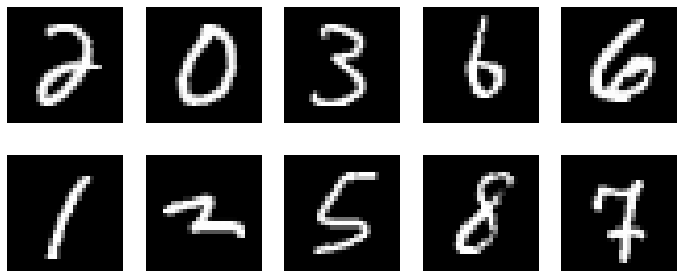

In [25]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,42000,size=10)
for i in range(10):
    axes[i].imshow(x_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    #axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()